In [1]:
import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

import flax.linen as nn
import optax
from flax.training.train_state import TrainState

key = jax.random.key(seed=1234)

In [41]:
# generate batch of step functions with a random jump position

def get_samples(key, batchsize, N=100):
    x = np.linspace(0,10, N)
    step_position=jax.random.uniform(key, (batchsize), minval=0., maxval=10.)
    fun=np.heaviside(x[None,:]-step_position[:,None],0)
    return fun, step_position, x

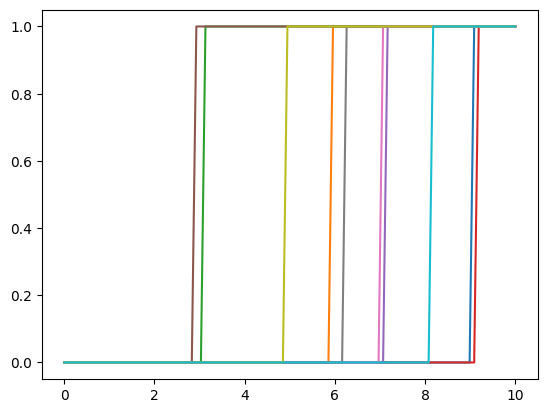

In [43]:
# plot a batch of example functions
y = get_samples(jax.random.key(seed=1234), 10)
plt.plot(y[-1], y[0].T)
plt.show()

In [51]:
# define the Autoencoder

# Your task: Define an Autoencoder using Flax. The Autoencoder gets as input a batch of functions of shape (batch_size, num_steps). 
# This input is compressed by by the Encoder to a bottleneck of size 1.
# The Decoder decodes the bottleneck again and returns an array of the shape (batch_size, num_steps)

# class Encoder(nn.Module):
#     @nn.compact
#     def __call__(self, x):
#         # TODO: write an Encoder
    
# class Decoder(nn.Module):
#     @nn.compact
#     def __call__(self, x):
#         # TODO: write a Decoder

# class Autoencoder(nn.Module):
#     # TODO: Write the Autoencoder


class Encoder(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(1)(x)
        return x
    
class Decoder(nn.Module):
    num_steps: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.num_steps)(x)
        x = nn.sigmoid(x)
        return x

class Autoencoder(nn.Module):
    num_steps: int

    @nn.compact
    def __call__(self, x):
        x = Encoder()(x)
        x = Decoder(self.num_steps)(x)
        return x
    
num_steps = 100
autoencoder = Autoencoder(num_steps)    

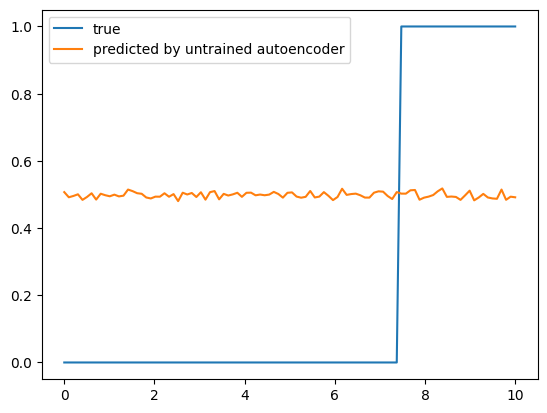

In [52]:
key, subkey = jax.random.split(key)
dummy_input, _, x = get_samples(subkey, 1, num_steps)
key, subkey = jax.random.split(key)
params = autoencoder.init(subkey, dummy_input)["params"]  # initialize the parameters

# apply the untrained autoencoder to a sample function
predicted = autoencoder.apply({'params': params}, dummy_input)
plt.plot(x, dummy_input[0], label='true')
plt.plot(x, predicted[0], label='predicted by untrained autoencoder')
plt.legend()

In [5]:
key, subkey = jax.random.split(key)
table = autoencoder.tabulate(subkey, dummy_input, column_kwargs=dict(overflow="fold"))
print(table)


                              Autoencoder Summary                               
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module      ┃ inputs        ┃ outputs        ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ Autoencoder │ float32[1,100 │ float32[1,100] │               │
│               │             │ ]             │                │               │
├───────────────┼─────────────┼───────────────┼────────────────┼───────────────┤
│ Encoder_0     │ Encoder     │ float32[1,100 │ float32[1,1]   │               │
│               │             │ ]             │                │               │
├───────────────┼─────────────┼───────────────┼────────────────┼───────────────┤
│ Encoder_0/Den │ Dense       │ float32[1,100 │ float32[1,1]   │ bias:         │
│ se_0          │             │ ]             │                │ float32[1]    │
│               │          

In [6]:
# create a generator, that generates new samples with every call

def make_batch_generator(key):
    while True:
        key, subkey = jax.random.split(key)
        data_batch = get_samples(subkey, batchsize=32, N=num_steps)
        yield data_batch

key = jax.random.key(seed=1234)
batch_generator = make_batch_generator(key)

In [44]:
# initialize the Adam optimizer
optimizer = optax.adam(learning_rate=0.001)
state = TrainState.create(apply_fn=autoencoder.apply, params=params, tx=optimizer)
losses = []

In [45]:
# Define the training function

@jax.jit
def train_on_batch(state, inputs, targets):

    def loss_fn(params):
        y_pred = state.apply_fn({'params': params}, inputs)
        sq_dev = (y_pred - targets)**2
        mean_sq_dev = sq_dev.mean()
        return mean_sq_dev

    val_and_grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = val_and_grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return loss, state

In [46]:
for i in range(10000):

    functions, step_positions, x = next(batch_generator)
    y_true = functions

    loss, state = train_on_batch(state, functions, functions)

    losses.append(loss)

    if (i) % 500 == 0:
        print(f"Batch: {i + 1}\tloss = {loss:.3e}")

Batch: 1	loss = 2.560e-01
Batch: 501	loss = 1.710e-01
Batch: 1001	loss = 9.728e-02
Batch: 1501	loss = 6.140e-02
Batch: 2001	loss = 4.825e-02
Batch: 2501	loss = 3.939e-02
Batch: 3001	loss = 3.056e-02
Batch: 3501	loss = 2.566e-02
Batch: 4001	loss = 2.586e-02
Batch: 4501	loss = 2.301e-02
Batch: 5001	loss = 1.979e-02
Batch: 5501	loss = 1.855e-02
Batch: 6001	loss = 1.540e-02
Batch: 6501	loss = 1.408e-02
Batch: 7001	loss = 1.266e-02
Batch: 7501	loss = 1.501e-02
Batch: 8001	loss = 1.252e-02
Batch: 8501	loss = 1.319e-02
Batch: 9001	loss = 1.051e-02
Batch: 9501	loss = 1.090e-02


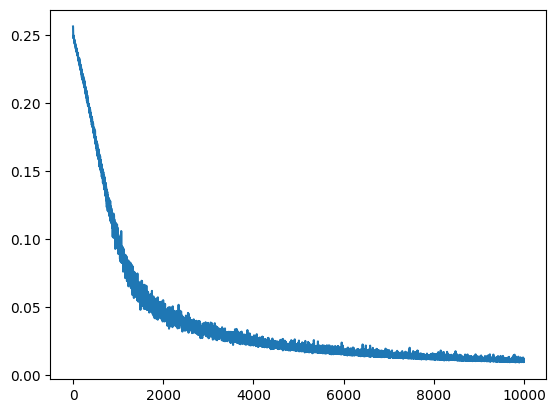

In [47]:
plt.plot(losses)

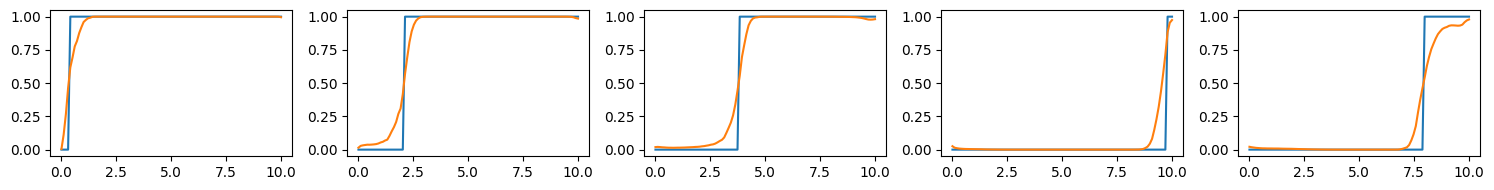

In [48]:
functions, step_positions, x = next(batch_generator)
predicted_functions = autoencoder.apply({'params': state.params}, functions)

functions_to_plot = 5
fig, axes = plt.subplots(ncols=functions_to_plot, figsize=(3*functions_to_plot, 2))
for idx in range(functions_to_plot):
    axes[idx].plot(x, functions[idx])
    axes[idx].plot(x, predicted_functions[idx])
fig.tight_layout()

In [49]:
encoder = Encoder()
params_enc = state.params['Encoder_0']
bottleneck_values = encoder.apply({'params': params_enc}, functions)

Text(0, 0.5, 'step position')

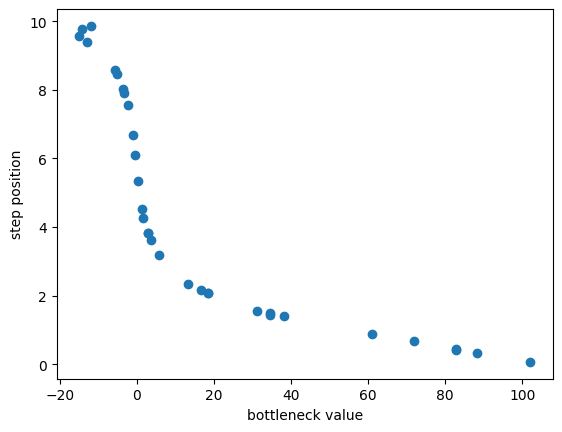

In [50]:
# Show correlation between the position of the step and the value of the bottleneck

plt.scatter(bottleneck_values, step_positions)
plt.xlabel('bottleneck value')
plt.ylabel('step position')